## Spiking data on Nengo - Tutorial
[Code cred](https://www.nengo.ai/nengo-examples/loihi/dvs-from-file.html)  
This tutorial covers the following:
- Format of spiking camera data
- How to read spiking camera data
- How to run spiking camera data through Nengo neurons
***
#### Motivation
Many times we process spiking data into regular images, then perform image processing (such as detection and classification) using traditional CPUs. This is a valid way to do things!   

BUT WHAT IF we instead feed the spiking data straight into neurons?? We can then just perform the image processing with neurons as well, further reducing power consumption and keeping the dimensionality of data reduced to events.  
 
***

### Resources
If you are interested in using spiking data for your final project, take a look at a bunch of options [here](https://rpg.ifi.uzh.ch/davis_data.html), [here](https://www.frontiersin.org/journals/neuroscience/articles/10.3389/fnins.2016.00405/full), and [here](https://docs.prophesee.ai/stable/datasets.html#chapter-datasets)
 -- or ask Dr. York or the Physics department.

[This website](https://rpg.ifi.uzh.ch/research_dvs.html) consolidates a lot of spiking-data resources.

[This survey paper](https://rpg.ifi.uzh.ch/docs/EventVisionSurvey.pdf) discusses different event-based cameras available and how they are processed in sections 2.5 and 3.1 respectively.  
  
***

#### Set up

**Ensure you are using your [495 Virtual Environment](https://github.com/kaitlin-fair/495venv_setup) before you begin!**  
    
Then, import Nengo, and other supporting libraries into your program to get started:

In [260]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import HTML
from matplotlib.animation import ArtistAnimation

import nengo

import pandas as pd

### Load your data (in the correct format)

Hopefully you recall our discussion on event-based data earlier in the semester. If not, take a look back at Lecture 6.

Hopefully you also recall building and utilizing Address Event Representation during our Path Planning lab. Combine those two concepts and you have spiking-camera data.

We have spiking-camera data containing pixel-coordinates with a timestamp of an event occuring along with it's polarity (0 or 1) from the Physics department as well as from Dr. York. This data is stored in a *.csv file. We will read the *.csv file and convert it to an input array using `csv_to_event_array`, we will then use the array as our input using a Nengo node that calls `readSpikeData`.

The *.csv files contain an array for every event consisting of the following values:   
- `x`: The horizontal coordinate of the event.
- `y`: The vertical coordinate of the event.
- `p`: The polarity of the event (0 for off, 1 for on).
- `t`: The event timestamp in microseconds.

The `readSpikeData` function will send 1's as input at each time step at which there is an event. Each x-y location (i.e. pixel) will connect to a neuron. There will be both a positive and negative neuron for each pixel.

**Other fun things about data**  
We can also generate data if we don't have our own (copy code from [here](https://www.nengo.ai/nengo-examples/loihi/dvs-from-file.html)). AND there are even Github repositories [like this one](https://github.com/SensorsINI/v2e) out there where you can take any data you'd like and convert it to spiking data like this. 

In [261]:
def csv_to_event_array(csv_filename: str, start_frame: int, end_frame: int) -> np.ndarray:
    # ======= DVS camera - Physics dept ===========
    df = pd.read_csv(csv_filename, names=['x', 'y', 'p', 't'])
    
    # set initial time to 0 for Nengo simulator to run data right away
    sub_df = df[(start_frame <= df['t']) & (df['t'] <= end_frame)]

    sub_df['t'] = sub_df['t'] - sub_df['t'].iloc[0]

    events_list = [(y, x, p, t) for x, y, p, t in sub_df.values]
    events_array = np.array(events_list, dtype=[('y', 'i4'), ('x', 'i4'), ('p', 'i4'), ('t', 'i4')])

    return events_array

# the csv file we will convert and the time range of our events

# ======= DVS camera - Physics dept ===========
# csv_filename = 'ILAN City Frame Data.csv'
# start_time = 585861
# end_time = 685846
# =============================================

# ======== Prophesee camera - ECE dept ========
csv_filename = 'newledpath.csv'
start_time = 0.95e6
end_time = 1.1e6
# =============================================

# Our events array we will feed in through a Nengo node
events = csv_to_event_array(csv_filename, start_time, end_time)
print("Successfully read %r" % csv_filename)

C:\Users\C27Grant.Stec\AppData\Local\Temp\ipykernel_13320\1456330843.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_df['t'] = sub_df['t'] - sub_df['t'].iloc[0]


Successfully read 'newledpath.csv'


### View the data (NOT using neurons yet)

This is all just a lot of python-ness to display a video. _Big takeaway_ - we are adding up events over a window of time. Our events occur over the course of 100ms. We take 10ms chunks and set any pixels within that 100ms with an event to 1 (or -1 should we have a polarity of 0). This gives us 10 frames.

You can read all about animations [here](https://matplotlib.org/stable/users/explain/animations/animations.html).

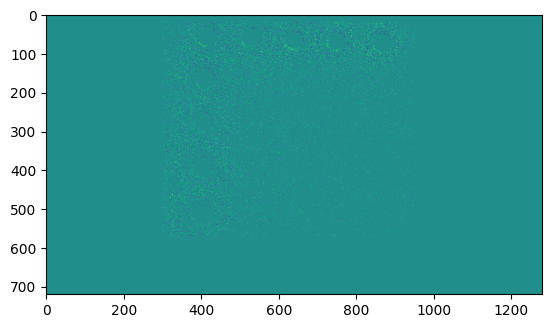

In [262]:
# ======== Prophesee camera - ECE dept ========
img_height = 720
img_width = 1280
t_length_us = end_time - start_time #value is in microseconds
t_length_s = t_length_us * 1e-6 #convert prior value to seconds
dt_frame_us = (10 * 1e-3) * 1e6 #this value is also in microseconds
t_frames = dt_frame_us * np.arange(int(round(t_length_us / dt_frame_us))) #number of frames in video
# =============================================

# ======= DVS camera - Physics dept ===========
# img_height = 180
# img_width = 240
# t_length_us = end_time - start_time #value is in microseconds
# t_length_s = t_length_us * 1e-6 #convert prior value to seconds
# dt_frame_us = (10 * 1e-3) * 1e6 #this value is also in microseconds
# t_frames = dt_frame_us * np.arange(int(round(t_length_us / dt_frame_us))) #number of frames in video
# =============================================

fig = plt.figure()
imgs = []
for t_frame in t_frames:
    t0_us = t_frame
    t1_us = t0_us + dt_frame_us
    t = events[:]["t"]
    m = (t >= t0_us) & (t < t1_us)
    events_m = events[m]

    # Empty frame
    frame_img = np.zeros((img_height, img_width))

    for sub_event in events_m:
        # show "off" (0) events as -1 and "on" (1) events as +1
        event_sign = 2.0 * sub_event["p"] - 1
        frame_img[sub_event["y"], sub_event["x"]] = frame_img[sub_event["y"], sub_event["x"]] + event_sign
    
    img = plt.imshow(frame_img[:, ::1], vmin=-1, vmax=1, animated=True)
    imgs.append([img])

ani = ArtistAnimation(fig, imgs, interval=50, blit=True)
HTML(ani.to_jshtml())

### Read Spike Data function to input into Nengo
We can now load our data into a Nengo model using the `readSpikeData` function we will create. Input arguments to this function are:
- `data`:The path of the file to read from. Can be a .aedat or .events file. Format of the file will be detected from the file extension.
- `pool`: Number of pixels to pool over in the vertical and horizontal directions, respectively. The larger the pool, the fewer neurons required. **Currently not working - must use [1 1].**
- `img_height` and `image_width`: Dimensions of the camera data.

Note that we can have positive (leading edge) and negative (trailing edge) spikes from our camera called the polarity of the event. In this case we have 2: one for positive events, one for negative. The first half of our neurons represent positive events, the second half negative.

In [263]:
# We'll make a simple object to implement the delayed connection
class readSpikeData:
    def __init__(self, event_data, img_height, img_width):
        self.xvals = event_data[:]["x"]
        self.yvals = event_data[:]["y"]
        self.time = event_data[:]["t"] 
        self.pol = event_data[:]["p"]
        self.img_ht = img_height
        self.img_wt = img_width

    def step(self, t):

        dt = .001
        t_lower = (t - dt) * 1e6
        t_upper = t * 1e6
        x = 0

        times = self.time
        indices = np.nonzero((times >= t_lower) & (times < t_upper))[0]

        data = np.zeros((self.img_ht*self.img_wt*2,), dtype=int)
        for index in indices:
            if self.pol[index] == 1:
                x += 1
                # Manually flatten data using (i*y_len)+j **note x,y vals swapped
                data[self.yvals[index]*self.img_wt + self.xvals[index]] = 1/dt 
            else:
                data[self.img_ht*self.img_wt + self.yvals[index]*self.img_wt + self.xvals[index]] = 1/dt
        return data

inp = readSpikeData(events, img_height, img_width)

### Build your model

This should all look familiar! We are feeding in our input values (i.e. our spike data) through a node, representing the pixel changes with neurons, and reading the data out using probes.

In [264]:
# ======= DVS camera - Physics dept ===========
#pool = (1, 1)

# ======== Prophesee camera - ECE dept ========
pool = (10, 10)

model = nengo.Network(label="Spiking Data")
with model:
    input_node = nengo.Node(inp.step)

    input_neurons = nengo.Ensemble(img_height * img_width * 2, 1)

    nengo.Connection(input_node, input_neurons.neurons, transform=1)

    probes_nodes = nengo.Probe(input_node)
    probes = nengo.Probe(input_neurons.neurons)

   
    pixel_range = 10 #the range of pixels from left to right and top to bottom so 10 creates a 10x10 square centered at the declared center
    probestart = [] #list of probes for the neurons activated around the first LED
    center_x = 400 #visually esatimated center of the first LED x
    center_y = 515 #visually estimated center of the first LED y
    pixel_coordinates = [] #list of the pixel coordinates that are being probed for first LED
    probeend = [] #list of probes for the neurons activated around the last LED
    centerend_x = 860 #visually estimated center of the last LED x
    centerend_y = 60 #visually estimated center of the last LED y
    pixelend_coordinates = [] #list of the pixel coordinates that are being probed for last LED

    #loop to get the neurons cordinated around the center 
    for i in range(-pixel_range//2, pixel_range//2 + 1):
        for j in range(-pixel_range//2, pixel_range//2 + 1):
            #for start
            x = center_x + i
            y = center_y + j
            index = (y * 1280) + x # correctly indexes to the flattened data in last code block
            pixel_coordinates.append(index)
            #for end
            xend = centerend_x + i
            yend = centerend_y + j
            indexend = (yend * 1280) + xend # correctly indexes to the flattened data in last code block
            pixelend_coordinates.append(indexend)
    #loop to create the probes for the neurons around the center
    for k in range (0, len(pixel_coordinates)):
        probestart.append(nengo.Probe(input_neurons.neurons[(pixel_coordinates[k])]))
        #for end 
        probeend.append(nengo.Probe(input_neurons.neurons[(pixelend_coordinates[k])]))

    
with nengo.Simulator(model) as sim:
    sim.run(t_length_s)








Build finished in 0:00:11.                                                      
Simulation finished in 0:00:24.                                                 


Average start time
40.0
Average end time
126.0
travel time
86.0
Random neuron around the first LED
4
Random neuron around the last LED
72


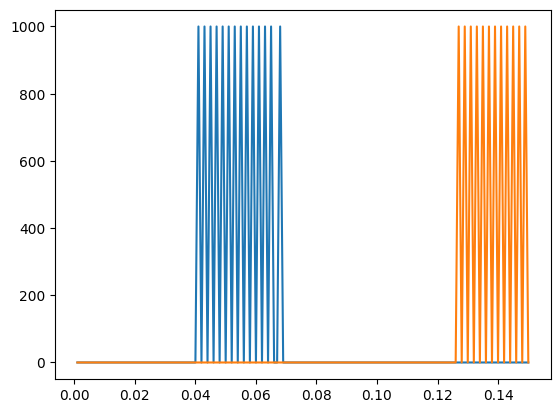

In [307]:
#algorithim to get the time of the first LED and Last LED

#initial variables and ists
sim_t = sim.trange()
timelist = [] 
neuron_data_start = []
neuron_data_end = []
timelistend = []


for n in range (0, len(pixel_coordinates)): #loop to get the data for each neuron around the first and last LED, since both cover 10x10 area of neurons the lenght of either list can be used
    start_spiking = False
    end_spiking = False
    for i in range (0, len(sim_t)): #loop to get the data for each time step, uses the length of the simulation time as each time step is 1ms
        neuron_data_start.append(sim.data[probestart[n]]) #list of the probed data for the neurons around the first LED
        neuron_data_end.append(sim.data[probeend[n]]) #list of the probed data for the neurons around the last LED
        if start_spiking is False and neuron_data_start[n][i] > 0 and neuron_data_start[n][i+2] > 0: #added i+2 to make sure the spike is not a fluke,two timsteps ahead becuase it takes one to go back down to 0 and then another to go back up to 1.
            time = [n,i] #list of the neuron index, and time of spike
            timelist.append(time) #list of all the neurons that spiked around the first LED
            start_spiking = True
        if end_spiking is False and neuron_data_end[n][i] > 0 and neuron_data_end[n][i+2] > 0: #added i+2 to make sure the spike is not a fluke
            timeend = [n,i] #list of the neuron index, and time of spike
            timelistend.append(timeend) #list of all the neurons that spiked around the last LED
            end_spiking = True
        
# #computing avg start time
timesumstart = 0
for i in range(0, len(timelist)): 
    timesumstart += timelist[i][1]
avg = timesumstart/len(timelist)

#computing avg end time
timesumend = 0
for i in range(0, len(timelistend)):
    timesumend += timelistend[i][1]
avgend = timesumend/len(timelistend)

print("Average start time")
print(avg)
print("Average end time")
print(avgend)

print("travel time")
print(avgend-avg)

from random import randrange

start = randrange(100)
end = randrange(100)

plt.plot(sim_t, neuron_data_start[start], label='Positive Spikes') #shows an example graph of the data for a random neuron around the first LED
plt.plot(sim_t, neuron_data_end[end], label='Negative Spikes') #shows an example graph of the data for a random neuron around the last LED
print("Random neuron around the first LED")
print(start)
print("Random neuron around the last LED")
print(end)

### View the data (using Nengo neurons!)

This looks very much the same as viewing the data with regular Python - except now we are reading spikes from our probed neurons!

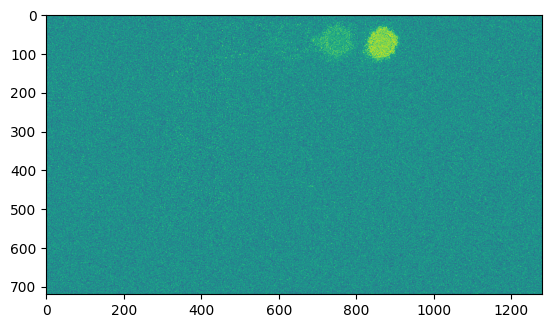

In [266]:
sim_t = sim.trange()
shape = (len(sim_t), img_height, img_width)

output_spikes_pos = sim.data[probes][:,0:img_height*img_width].reshape(shape) * sim.dt
output_spikes_neg = sim.data[probes][:,img_height*img_width:img_height*img_width*2].reshape(shape) * sim.dt

dt_frame = 0.01 # this is in seconds
t_frames = dt_frame * np.arange(int(round(t_length_s / dt_frame)))

fig = plt.figure()

imgs = []
for t_frame in t_frames:
    t0 = t_frame
    t1 = t_frame + dt_frame
    m = (sim_t >= t0) & (sim_t < t1)

    frame_img = np.zeros((img_height, img_width))
    frame_img -= output_spikes_neg[m].sum(axis=0)
    frame_img += output_spikes_pos[m].sum(axis=0)
    frame_img = frame_img / np.abs(frame_img).max()

    img = plt.imshow(frame_img[:, ::1], vmin=-1, vmax=1, animated=True)
    imgs.append([img])

ani = ArtistAnimation(fig, imgs, interval=50, blit=True)
HTML(ani.to_jshtml())



### Discussion

This simulation starts at t=0 and runs through full t=1. So we just have noise on either side of the actual data whereas using regular python we only plotted the data of interest.

Also notice the noise is HIGH. That's because neurons are inherently noisy. 

**_So again, why did we do this?_**   

It seemed like a lot of work to just print the data again... right??

Well, now we know we can effectively send the data through neurons, which means we can now start processing the data with neurons and maintain the efficiencies we gained by collecting event-based data in the first place. COOL!